## <span style=color:blue>Playing with a very basic Crop Yield Forecasting model </span>

In [3]:
# These are boiler plate imports that seem useful
# I should probably delete or comment out the ones that aren't used in this script...

import sys
import json
import csv
import yaml

import pandas as pd
import numpy as np

import matplotlib as mpl
from cycler import cycler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

sys.path.append('/Users/rick/HACKING/UTILITIES_IN_HACKING/')
import utils_general

from owlready2 import *

print('Success with initialization')

Success with initialization


### <span style=color:blue>Review of the "exponential decay function" and "one-minus exponential decay function"</span>

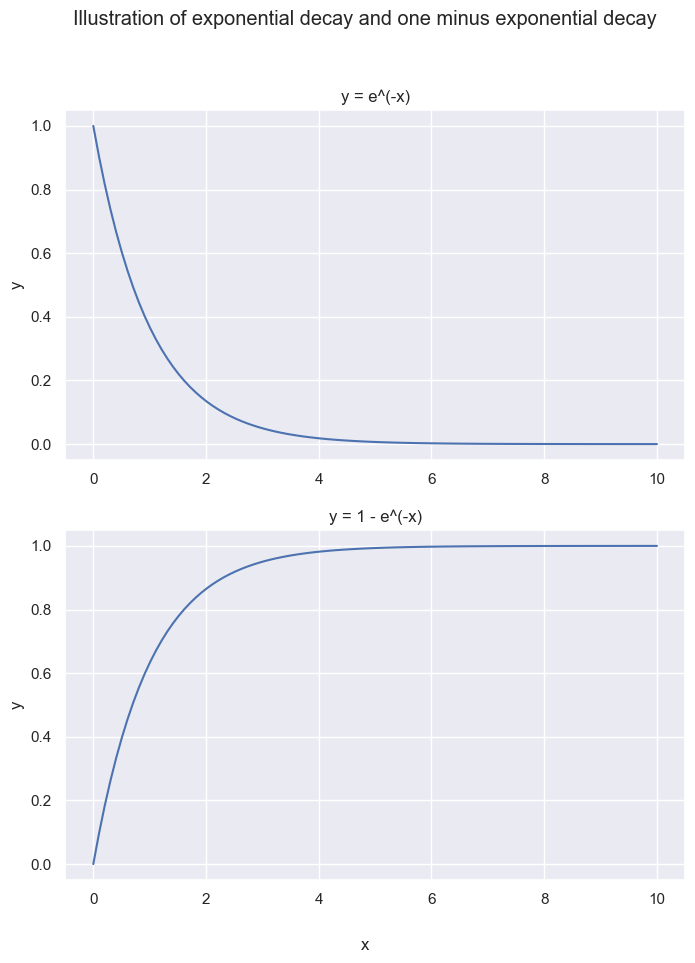

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def g(x):
    return np.exp(-x)

def f(x):
    return 1 - np.exp(-x)


# define the range of x values to be used for the graphs
x = np.linspace(0, 10, 100)

# define the functions to be plotted
y1 = g(x)
y2 = f(x)
    
# create stack of subplots with height = length
fig, axs = plt.subplots(2,1,figsize=(8,10))

# plot each graph in successive subplots, and label the 'y' axis


axs[0].plot(x,y1)
axs[1].plot(x,y2)
axs[0].set_title('y = e^(-x)')
axs[1].set_title('y = 1 - e^(-x)')
axs[0].set_ylabel('y')
axs[1].set_ylabel('y')
# axs[1].set_xlabel('x')

# add axis labels and a main title
fig.suptitle('Illustration of exponential decay and one minus exponential decay')
fig.text(0.5, 0.04, 'x', ha = 'center')
# fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')

# Display plot
plt.show()

## <span style=color:blue>Now implementing the simple crop forecast model from Chapter 1 of the book "Working with Dynamic Crop Models". </span>

### <span style=color:blue>First step is to initialize a bunch of variables. </span>


In [83]:
# (Static) input parameters to the simulation
# These are about the type of plant being simulated
# For now, I am just making these numbers up to see how the simulation behaves
T_base = 40  # Baseline temperature for growth
RUE = 0.05   # Radiation Use Efficiency
             #    cf slides from MS State "Solar Radiation.pdf"
K = 0.3      # Excitation coefficient, which determines the relation 
             #   between leaf area index and intercepted radiation;
alpha = 0.001    # relative rate of LAI increase for small values of LAI
LAI_max = 4  # max LAI
TT_M = 1600  # temperature sum (above T_base) for crop maturity (for now, 20 deg * 80 days)
TT_L = 1000  # temperature sum (above T_base) at the end of LAI increase (for now, 20 deg * 50 days)

# "State" variables, which will be modified for each day during the simulation
TT = {}      # Total Temperature above "base for growth" experienced 
             #     by plant to current day
B = {}       # plant Biomass on current day
LAI = {}     # Leaf Area index on current day
        # Could also include, e.g.,
        #    -- root depth
        #    -- soil water conent in each of several soil layers
        #    See Chapter 9 of the book for other examples

# "Explanatory" input parameters - these are about the particular 
#     simulation that we are running, e.g., weather and soil conditions
#     for this simulation
TMin = {}    # min temp for current day
TMax = {}    # max temp for current day
I = {}       # radiation on current day (assuming per W per m^2)
        # other Explanatory parameters might include 
        #    -- initial conditions, e.g., initial soil moisture
        #    -- soil characteristics, e.g., max water holding capability
        #    -- management variables, e.g., irrigation amounts/dates and
        #           fertilization types/amounts/dates

# Giving TMin, TMax, I some values for days 0 to 100
# Very simple for now
for i in range(0,100):
    TMin[i] = round(70 - 10 * (abs(50-i)/25),1)  # from 50 to 70, with peak at day 50
    TMax[i] = round(90 - 10 * (abs(50-i)/25),1)  # from 70 to 90, with peak at day 50
    I[i] = 1/10 * round(30 - 5 * (abs(50-i)/25),1)  # from 20 to 30, with peak at day 50
              # assuming the unit is MJ/m^2...

# for i in range(0,100):
#     print(TMin[i], TMax[i], I[i])


### <span style=color:blue>Defining function that corresponds to executing one day in a simulation using this crop yield forecast model </span>

In [99]:
# Function that maps vector of TT, B, LAI for one day to corresponding
#    value on the next day
# Restrictions:
#    day should be between 0 and 99, because 

def add_day(TT_curr, B_curr, LAI_curr, day, verbose):
    if verbose:
         print('inputs are: ', TT_curr, B_curr, LAI_curr, day)
    if day < 0 or day >= 100:
        print('Invalid input, variable "day" is out of bounds')
        return 0,0,0

    # defining TT_delta
    TT_delta = max(0, (TMin[day] + TMax[day])/2 - T_base)
    if verbose:
         print('TT_delta is: ', TT_delta)
    
    # defining B_delta
    if TT_curr <= TT_M:
        B_delta = RUE * (1-np.exp(-K * LAI_curr)) * I[day]        
        if verbose:
            print('key values for defining B_delta are as follows:')
            print('        ', 'RUE: ', RUE)
            print('        ', 'K: ', K)
            print('        ', 'LAI_curr: ', LAI_curr)
            print('        ', '-K*LAI_curr: ', -K*LAI_curr)
            print('        ', 'np.exp(-K*LAI_curr): ', np.exp(-K*LAI_curr))
            print('        ', 'I[day]: ', I[day])
    else:
        B_delta = 0
    if verbose:
        print('B_delta is: ', B_delta)
    
    # defining LAI_delta
    if TT_curr <= TT_L:
        LAI_delta = alpha * TT_delta \
                          * LAI_curr \
                          * max(0, LAI_max - LAI_curr)
        if verbose:
            print('key values for defining LAI_delta are as follows:')
            print('        ', 'alpha: ', alpha)
            print('        ', 'TT_delta: ', TT_delta)
            print('        ', 'LAI_curr: ', LAI_curr)
            print('        ', 'LAI_max: ', LAI_max)
            print('        ', 'LAI_max-LAI_curr: ', LAI_max-LAI_curr)
    else:
        LAI_delta = 0
    if verbose:
        print('LAI_delta is: ', LAI_delta)
    
    TT_next = TT_curr + TT_delta
    B_next = B_curr + B_delta
    LAI_next = LAI_curr + LAI_delta
    
    if verbose:
        print('outputs are: ', 
              round(TT_next, 2),
              round(B_next, 2),  
              round(LAI_next, 2))
               
    return TT_next, B_next, LAI_next

TT, B, LAI = add_day(500, 200, 2, 30, True)

inputs are:  500 200 2 30
TT_delta is:  32.0
key values for defining B_delta are as follows:
         RUE:  0.05
         K:  0.3
         LAI_curr:  2
         -K*LAI_curr:  -0.6
         np.exp(-K*LAI_curr):  0.5488116360940265
         I[day]:  2.6
B_delta is:  0.058654487307776566
key values for defining LAI_delta are as follows:
         alpha:  0.001
         TT_delta:  32.0
         LAI_curr:  2
         LAI_max:  4
         LAI_max-LAI_curr:  2
LAI_delta is:  0.128
outputs are:  532.0 200.06 2.13


### <span style=color:blue>Function to run the simulation for n days. </span>

In [100]:
def run_simulation(days):
    TT = {}
    B = {}
    LAI = {}
    TT[0] = 0
    B[0] = 0
    LAI[0] = 0.5
    
    for d in range(0,days):
        TT[d+1], B[d+1], LAI[d+1] = add_day(TT[d], B[d], LAI[d], d, False)
        
    return TT, B, LAI

TT_sim, B_sim, LAI_sim = run_simulation(100)

print(json.dumps(TT_sim, indent=4), '\n', 
      json.dumps(B_sim, indent=4), '\n', 
      json.dumps(LAI_sim, indent=4))

{
    "0": 0,
    "1": 20.0,
    "2": 40.400000000000006,
    "3": 61.2,
    "4": 82.4,
    "5": 104.0,
    "6": 126.0,
    "7": 148.4,
    "8": 171.2,
    "9": 194.39999999999998,
    "10": 217.99999999999997,
    "11": 241.99999999999997,
    "12": 266.4,
    "13": 291.2,
    "14": 316.4,
    "15": 342.0,
    "16": 368.0,
    "17": 394.4,
    "18": 421.2,
    "19": 448.4,
    "20": 476.0,
    "21": 504.0,
    "22": 532.4,
    "23": 561.1999999999999,
    "24": 590.4,
    "25": 620.0,
    "26": 650.0,
    "27": 680.4,
    "28": 711.1999999999999,
    "29": 742.4,
    "30": 774.0,
    "31": 806.0,
    "32": 838.4,
    "33": 871.1999999999999,
    "34": 904.4,
    "35": 938.0,
    "36": 972.0,
    "37": 1006.4,
    "38": 1041.2,
    "39": 1076.4,
    "40": 1112.0,
    "41": 1148.0,
    "42": 1184.4,
    "43": 1221.2,
    "44": 1258.4,
    "45": 1296.0,
    "46": 1334.0,
    "47": 1372.4,
    "48": 1411.2,
    "49": 1450.4,
    "50": 1490.0,
    "51": 1530.0,
    "52": 1569.6,
    "53": 

### <span style=color:blue>Graphing the 3 output dictionaries </span>

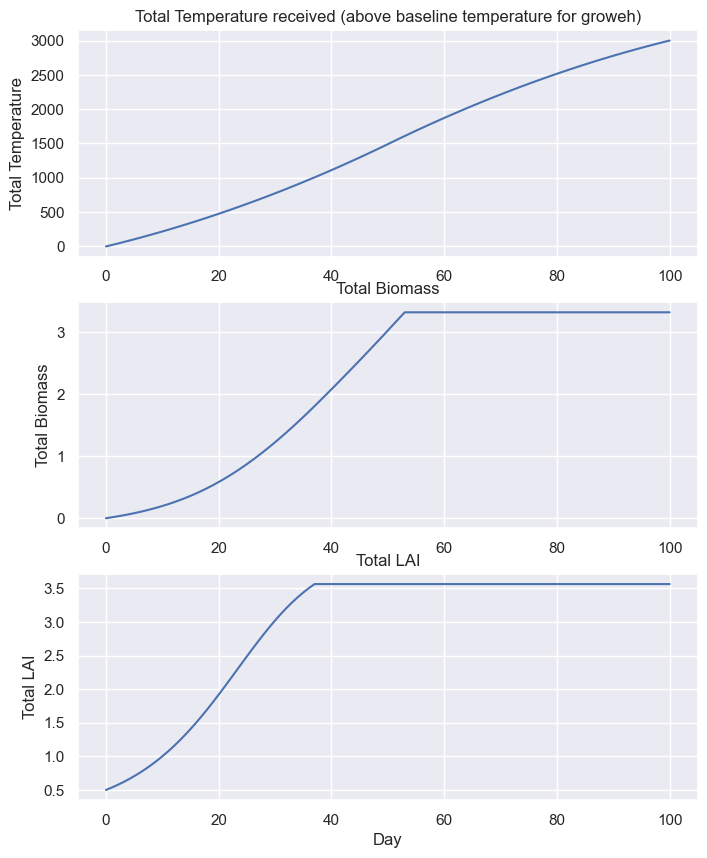

In [104]:
import math
import matplotlib.pyplot as plt

# create stack of subplots with height = length
fig, axs = plt.subplots(3,1,figsize=(8,10))

# plot each graph in successive subplots

axs[0].plot(TT_sim.keys(), TT_sim.values())
axs[1].plot(B_sim.keys(), B_sim.values())
axs[2].plot(LAI_sim.keys(), LAI_sim.values())

axs[0].set_title('Total Temperature received (above baseline temperature for groweh)')
axs[1].set_title('Total Biomass')
axs[2].set_title('Total LAI')
axs[0].set_ylabel('Total Temperature')
axs[1].set_ylabel('Total Biomass')
axs[2].set_ylabel('Total LAI')
# axs[0].set_xlabel('Day')
# axs[1].set_xlabel('Day')
axs[2].set_xlabel('Day')


# Display plot
plt.show()
